# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




## Team 9

* Jessica Giovana García Gómez: A01795922
* Alejandro González Almazán: A00517113
* Esteban Sebastián Guerra Espinoza: A01795897
* Jossie Paola Jiménez Rivera: A01795961
* Paúl Andrés Yungán Pinduisaca: A01795702

### Prepare libaries

In [68]:
import numpy as np # Used for working with multidimensional arrays and mathematical operations
import torch #PyTorch deep learning framework
import torch.nn as nn #For building and training neural networks
import torch.nn.functional as F #For cross_entropy

from torch.utils.data import DataLoader #Load datasets in batches
from torch.utils.data import sampler #Defines strategy of sampling, like random
import torchvision.datasets as datasets #datasets dor training and evaluating the model
import torchvision.transforms as T #Convert tensors, normalize and compose

from torchvision import models

In [69]:
import matplotlib.pyplot as plt # For data visualization
import os  # Used to handle file paths, directories, etc.

#Steps required to open google drive from google.colab import drive

In [70]:
#Open current directory
cwd = os. getcwd()

### Download datasets

In [71]:
DATA_PATH = cwd + 'cifar-10-batches-py'  #Image repository
NUM_TRAIN = 45000 #Training Set
MINIBATCH_SIZE = 64

#Compose a series of transformations, allows to make transformations to the images, modifications such as rotations, in this case it is used to convert to a tensor and normalize.
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

In [72]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### GPU Use

In [73]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Show images

La imagen muestreada representa un: Frog


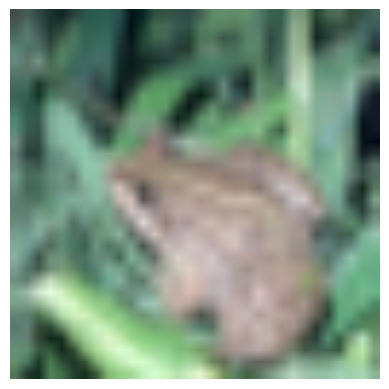

In [75]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calculate Accuracy

In [76]:
""""-------------------------------------------------------------------
  Function: accuracy
  Parameters:
    model (Sequential_layers): Sequential model that processes the inputs.
    loader (DataLoader):       Dataloader with batches for training or evaluation.

  Returns:
    accuracy (float): Accuracy value between 0 and 1, representing the
                      fraction of correctly classified samples.

  Description:
    This function calculates the accuracy of the model's predictions on a
    given dataset by comparing the predicted class indices to the actual
    target indices.
-------------------------------------------------------------------"""
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   



### Load pre-trained model 1: ResNet-18

In [10]:
#Loads a ResNet-18 model pre-trained on ImageNet.
model_resnet18 = models.resnet18(pretrained=True)

c:\Users\jopaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jopaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jopaz/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


#### Exploremos el modelo

In [11]:
#For each parameter in the model, print their index, shape, and if require gradients.
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [12]:
#Print the ResNet-18 model structure
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Adjust model

In [13]:
#model_aux will be a sequential model created from the child layers of model_resnet18.
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
#model_aux will be a sequential model created from the child layers of model_resnet18, without last layer: Linear(in_features=512, out_features=1000, bias=True)
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
#Eliminates gradient requirements
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False
    print(i, parameter.requires_grad)

### Loop de entrenamiento

In [18]:
""""-------------------------------------------------------------------
  Function: train
  Parameters:
    model (Sequential_layers):  Sequential model to train
    optimizer (Optimizer):      Optimizer tp update the parameters of a model to minimize the loss
    epochs (int):               The number of iterations over the entire training dataset (default is 100).

  Returns:
    

  Description:
    This function trains the provided sequential model by iterating over
    the given number of epochs. For each epoch, the model computes the loss using
    cross-entropy function.The accuracy of the model is printed
    at the end of each epoch using a validation dataset.
-------------------------------------------------------------------"""
def train(model, optimiser, epochs=100):
    model = model.to(device=device) # Move the model to the specified device (CPU or GPU)
    for epoch in range(epochs): # Iterate over the number of training epochs
        for i, (xi, yi) in enumerate(train_loader):     # Loop through mini-batches from the training data
            model.train()                               # Set the model to training mode (enables dropout and batch norm updates)

            xi = xi.to(device=device, dtype=torch.float32)  # Move input data to the device and set type to float32
            yi = yi.to(device=device, dtype=torch.long)     # Move labels to the device and set type to long (for classification)
            scores = model(xi)           # Forward pass: get model predictions (logits)

            cost = F.cross_entropy(input= scores, target=yi)    # Compute the loss using cross-entropy (for classification)
        
            optimiser.zero_grad()           # Reset gradients to prevent accumulation from previous iterations
            cost.backward()                 # Compute gradients using backpropagation
            optimiser.step()                # Update model parameters using the optimizer
            
        acc = accuracy(model, val_loader)   # Compute the accuracy of the model on the validation dataset
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},') # Print epoch number, loss, and accuracy
#         scheduler.step()

In [19]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 3

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))


In [20]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [21]:
#Train the model with Adam optimiser and 3 epochs
train(model1, optimiser, epochs)

Epoch: 0, costo: 1.47697114944458, accuracy: 0.7798,
Epoch: 1, costo: 1.1249836683273315, accuracy: 0.7924,
Epoch: 2, costo: 0.8427524566650391, accuracy: 0.8014,


In [22]:
#resnet18 model accuracy:
accuracy(model1, test_loader)

0.7973

### Pre-trained model 1: Mobilenet

MobileNetV2 is based on inverted residuals and depthwise separable convolutions, making it computationally efficient.

The MobileNet v2 architecture is based on an inverted residual structure where the input and output of the residual block are thin bottleneck layers opposite to traditional residual models which use expanded representations in the input. MobileNet v2 uses lightweight depthwise convolutions to filter features in the intermediate expansion layer. Additionally, non-linearities in the narrow layers were removed in order to maintain representational power.

Input Layer: 224×224 RGB image
Feature Extractor: 17 bottleneck residual blocks
Classifier: Fully connected layer with 1000 classes (for ImageNet)

https://keras.io/api/applications/mobilenet/
https://la.mathworks.com/help/deeplearning/ref/mobilenetv2.html
https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

In [59]:
##Create a model
#Loads a MobileNet model pre-trained on ImageNet.
model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)

#### Adjust model

In [60]:
#Adjust the model
model_aux_mobilenet = nn.Sequential(
    *list(model_mobilenet_v2.children())[:-1],  # Excluir la última capa
    nn.AdaptiveAvgPool2d(1)  # Adaptar la salida a 1x1
)

In [62]:
# Definir el modelo final con capa de salida ajustada para 10 clases
model1_mobilenet = nn.Sequential(
    model_aux_mobilenet,
    nn.Flatten(),
    nn.Linear(in_features=1280, out_features=10, bias=True)  # 1280 características de MobileNetV2
)

# Configuración del optimizador
lr = 5e-4
optimiser_mobilenet = torch.optim.Adam(model1_mobilenet.parameters(), lr=lr, betas=(0.9, 0.999))

#### Train model

In [63]:
#Train the model with Adam optimiser and 3 epochs
train(model1_mobilenet, optimiser_mobilenet, epochs)

#MobileNetV2 model accuracy:
test_accuracy_mobilenet = accuracy(model1_mobilenet, test_loader)
print(f'MobileNetV2 Test Accuracy: {test_accuracy_mobilenet * 100:.2f}%')

Epoch: 0, costo: 0.019025038927793503, accuracy: 0.8892,
Epoch: 1, costo: 0.0727081298828125, accuracy: 0.8982,
Epoch: 2, costo: 0.053220510482788086, accuracy: 0.901,
MobileNetV2 Test Accuracy: 90.57%


### Pre-trained model 2: ResNet-101

Is a 101-layer deep version of the ResNet (Residual Network) architecture. It is a powerful convolutional neural network (CNN) commonly used for image classification, feature extraction, and transfer learning.

Parameters:
weights (ResNet101_Weights, optional) – The pretrained weights to use. See ResNet101_Weights below for more details, and possible values. By default, no pre-trained weights are used.

progress (bool, optional) – If True, displays a progress bar of the download to stderr. Default is True.

**kwargs – parameters passed to the torchvision.models.resnet.ResNet base class. Please refer to the source code for more details about this class.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet101.html
https://la.mathworks.com/help/deeplearning/ref/resnet101.html
https://la.mathworks.com/matlabcentral/fileexchange/65678-deep-learning-toolbox-model-for-resnet-101-network?s_tid=prof_contriblnk

In [77]:
##Create a model
#Loads a ResNet-101 model pre-trained on ImageNet.
model_resnet101 = models.resnet101(pretrained=True)

#For each parameter in the model, print their index, shape, and if require gradients.
for i, w in enumerate(model_resnet101.parameters()):
    print(i, w.shape, w.requires_grad)

#Print the ResNet-101 model structure
model_resnet101

c:\Users\jopaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 1, 1]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([256, 64, 1, 1]) True
10 torch.Size([256]) True
11 torch.Size([256]) True
12 torch.Size([256, 64, 1, 1]) True
13 torch.Size([256]) True
14 torch.Size([256]) True
15 torch.Size([64, 256, 1, 1]) True
16 torch.Size([64]) True
17 torch.Size([64]) True
18 torch.Size([64, 64, 3, 3]) True
19 torch.Size([64]) True
20 torch.Size([64]) True
21 torch.Size([256, 64, 1, 1]) True
22 torch.Size([256]) True
23 torch.Size([256]) True
24 torch.Size([64, 256, 1, 1]) True
25 torch.Size([64]) True
26 torch.Size([64]) True
27 torch.Size([64, 64, 3, 3]) True
28 torch.Size([64]) True
29 torch.Size([64]) True
30 torch.Size([256, 64, 1, 1]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([128, 256, 1, 1]) True
34 torch.Size([128]) True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Adjust model

In [78]:
#Adjust the model
#model_aux will be a sequential model created from the child layers of model_resnet101, without last layer: Linear(in_features=2048, out_features=1000, bias=True)
model_aux2 = nn.Sequential(*list(model_resnet101.children())[:-1])
print(model_aux2)
for i, parameter in enumerate(model_aux2.parameters()): parameter.requires_grad = False

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [79]:
model2 = nn.Sequential(model_aux2,
                       nn.Flatten(), 
                       nn.Linear(in_features=2048, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.999))

model2

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

#### Train model

In [81]:
#Train the model with Adam optimiser and 3 epochs
train(model2, optimiser, epochs)

#model_resnet101 model accuracy:
test_model_resnet101 = accuracy(model2, test_loader)
print(f'ResNet 101 Test Accuracy: {test_model_resnet101 * 100:.2f}%')


Epoch: 0, costo: 1.2751113176345825, accuracy: 0.8168,
Epoch: 1, costo: 0.7479812502861023, accuracy: 0.8378,
Epoch: 2, costo: 0.3807896375656128, accuracy: 0.8456,
ResNet 101 Test Accuracy: 83.76%


### Pre-trained model 3: EfficientNet B0


EfficientNet B0 model architecture from the EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks paper.

Parameters:
weights (EfficientNet_B0_Weights, optional) – The pretrained weights to use. See EfficientNet_B0_Weights below for more details, and possible values. By default, no pre-trained weights are used.

progress (bool, optional) – If True, displays a progress bar of the download to stderr. Default is True.

**kwargs – parameters passed to the torchvision.models.efficientnet.EfficientNet base class. Please refer to the source code for more details about this class.

The model builder above accepts the following values as the weights parameter. EfficientNet_B0_Weights.DEFAULT is equivalent to EfficientNet_B0_Weights.IMAGENET1K_V1. You can also use strings, e.g. weights='DEFAULT' or weights='IMAGENET1K_V1'.

https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html

In [82]:
##Create a model
#Loads a efficientnet_b0 model pre-trained on ImageNet.
model_efficientnet_b0 = models.efficientnet_b0(pretrained=True)

#For each parameter in the model, print their index, shape, and if require gradients.
for i, w in enumerate(model_efficientnet_b0.parameters()):
    print(i, w.shape, w.requires_grad)

#Print the efficientnet_b0 model structure
model_efficientnet_b0

c:\Users\jopaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jopaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0 torch.Size([32, 3, 3, 3]) True
1 torch.Size([32]) True
2 torch.Size([32]) True
3 torch.Size([32, 1, 3, 3]) True
4 torch.Size([32]) True
5 torch.Size([32]) True
6 torch.Size([8, 32, 1, 1]) True
7 torch.Size([8]) True
8 torch.Size([32, 8, 1, 1]) True
9 torch.Size([32]) True
10 torch.Size([16, 32, 1, 1]) True
11 torch.Size([16]) True
12 torch.Size([16]) True
13 torch.Size([96, 16, 1, 1]) True
14 torch.Size([96]) True
15 torch.Size([96]) True
16 torch.Size([96, 1, 3, 3]) True
17 torch.Size([96]) True
18 torch.Size([96]) True
19 torch.Size([4, 96, 1, 1]) True
20 torch.Size([4]) True
21 torch.Size([96, 4, 1, 1]) True
22 torch.Size([96]) True
23 torch.Size([24, 96, 1, 1]) True
24 torch.Size([24]) True
25 torch.Size([24]) True
26 torch.Size([144, 24, 1, 1]) True
27 torch.Size([144]) True
28 torch.Size([144]) True
29 torch.Size([144, 1, 3, 3]) True
30 torch.Size([144]) True
31 torch.Size([144]) True
32 torch.Size([6, 144, 1, 1]) True
33 torch.Size([6]) True
34 torch.Size([144, 6, 1, 1]) True


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### Adjust the model

In [83]:
#Adjust the model
#model_aux will be a sequential model created from the child layers of model_efficientnet_b0, without last layer: Linear(in_features=1280, out_features=1000, bias=True)
model_aux3 = nn.Sequential(*list(model_efficientnet_b0.children())[:-1])
print(model_aux3)
for i, parameter in enumerate(model_aux3.parameters()): parameter.requires_grad = False

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
    

In [84]:
model3 = nn.Sequential(model_aux3,
                       nn.Flatten(), 
                       nn.Linear(in_features=1280, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model3.parameters(), lr=lr, betas=(0.9, 0.999))

model3

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): Sigm

#### Train the model

In [86]:
#Train the model with Adam optimiser and 3 epochs
train(model3, optimiser, epochs)

#model_efficientnet_b0 model accuracy:
test_model_efficientnet_b0 = accuracy(model3, test_loader)
print(f'Eficientnet B0 Test Accuracy: {test_model_efficientnet_b0 * 100:.2f}%')

Epoch: 0, costo: 0.4327218532562256, accuracy: 0.8016,
Epoch: 1, costo: 0.772395133972168, accuracy: 0.8114,
Epoch: 2, costo: 0.5069098472595215, accuracy: 0.811,
Eficientnet B0 Test Accuracy: 80.62%
